# Functional model

In [1]:
#TODO: add warnings for things that shouldn't happen, e.g. symptoms lower than SMIN
#TODO: plotting methods and printing methods
#TODO: use Enums

In [95]:
# Simulations study parameters
FMIN = 6 #minimum possible visual score
SMIN = 0 #minimum possible symptom score
NDAYS = 160 #number of days in the study
FIRSTVISIT = 8
LASTVISIT = NDAYS-1

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from numpy import random
import numpy as np
random.seed(3) # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/

In [96]:
#helper functions

def uniform_to_normal(interval, pmsigma=3):
    '''
    Converts parameters for a uniform distribution to parameters for a normal distribution 

            Input:
                    interval (tuple of (float, float)): the interval boundaries (min and max)
                    pmsignma (float): half the standard deviations that the interval should comprise of
            Returns:
                    normal_params (tuple of (float, float)): mean and stdev
    '''
    mean = (interval[0]+interval[1])/2
    stdev = (interval[1]-interval[0])/(2*pmsigma)
    return (mean, stdev)

In [97]:
from types import MethodType

class Population:
    def __init__(self, size=10000, title='',
                 symptomfunctiontype='linear', errortype='multiplicative', 
                 gen_r=None, gen_f0=None, gen_a=None, gen_B=None, gen_C=None, gen_s0=None):
        
        self.title = title
        self.size = size
        
        #setting function types
        self.symptomfunctiontype = symptomfunctiontype
        self.errortype = errortype
        
        #setting parameter distributions if given by binding to the object instance
        if gen_r is not None:
            self.gen_r = MethodType(gen_r, self)
        if gen_f0 is not None:
            self.gen_f0 = MethodType(gen_f0, self)
        if gen_a is not None:
            self.gen_a = MethodType(gen_a, self)
        if gen_B is not None:
            self.gen_B = MethodType(gen_B, self)
        if gen_C is not None:
            self.gen_C = MethodType(gen_C, self)
        if gen_s0 is not None:
            self.gen_s0 = MethodType(gen_s0, self)
        
        #generating population parameters, 
        self.parameters = {
            #per person so vertical arrays
            'r': self.gen_r(size),
            'f0': self.gen_f0(size),
            'a': self.gen_a(size),
            'B': self.gen_B(size),
            's0': self.gen_s0(size),
            #per days so matrix
            'C': self.gen_C(size, NDAYS)
        }
        
        days = np.arange(NDAYS) #horizontal array
        #matrices of scores where rows are persons and columns are days
        self.visualscores = self.gen_visualscores(days, self.parameters['r'], self.parameters['f0'])
        self.symptomscores_noerror = self.gen_symptomscores_linear_noerror(self.visualscores, self.parameters['a'])
        self.symptomscores = self.gen_error_multiplicative(self.symptomscores_noerror, self.parameters['C'])
    
    def gen_visualscores(self, t, r, f0):
        #t is a non-negative integer for 'time in days'
        return np.maximum(-r*t+f0, FMIN)
    
    def gen_symptomscores_linear_noerror(self, f, a):
        return a*(f-FMIN)
    
    def gen_error_multiplicative(self, s, C):
        return s*C
    
    def gen_error_additive(self, s, C):
        return np.maximum(s+C, SMIN)
    
    def symptomscore(self, f):
        #f is a 'visual score'
        #functiontype is either 'linear', 'exponential', or 'linear with intercept'
        functiontype = self.population.symptomfunctiontype
        #errortype is either 'multiplicative' or 'additive'
        errortype = self.population.errortype
        
        if functiontype=='linear':
            symptoms_noerror = self.a*(f-FMIN)
        elif functiontype=='exponential':
            symptoms_noerror = self.a*(self.f0-FMIN)*(self.B**f-self.B**FMIN)/(self.B**self.f0-self.B**FMIN)
        elif functiontype=='linear with intercept':
            symptoms_noerror = self.a*f+self.s0
            
        if errortype=='multiplicative':
            return self.population.gen_C()*symptoms_noerror
        elif errortype=='additive':
            return max(self.population.gen_C()*symptoms_noerror, SMIN)
        
    #default parameter distributions
    def gen_r(self, size):
        return np.full(shape=(size, 1), fill_value=1)
    def gen_f0(self, size):
        return np.full(shape=(size, 1), fill_value=16)
    def gen_a(self, size):
        return np.full(shape=(size, 1), fill_value=1)
    def gen_B(self, size):
        return np.full(shape=(size, 1), fill_value=1.5)
    def gen_s0(self, size):
        return np.full(shape=(size, 1), fill_value=SMIN)
    def gen_C_multiplicative(self, size, days):
        return np.full(shape=(size, days), fill_value=1)
    def gen_C_additive(self, size, days):
        return np.full(shape=(size, days), fill_value=0)
    def gen_C(self, size, days):
        return self.gen_C_multiplicative(size, days)

    #removing outliers
    def filter(self):
        def isTypicalRecovery(person):
            if (min(person.symptomscores[:FIRSTVISIT] <= SMIN)): #if at some point before first visit symptoms go to 'recovered'
                return False #person 'cancels the appointment
            elif (min(person.symptomscores) > SMIN): #if symptoms never go to 'recovered'
                return False #excluded from study because considered 'chronic'
            else:
                return True #typical patient
        filtered_pop = Population(0)
        filtered_pop.persons = filter(isTypicalRecovery, self.persons)
        #change size attribute
        return filtered_pop
    
    #plotting
    def plot(self, ax, ndays=NDAYS, npersons=None, score='symptom'):
        #score is either 'symptom', 'visual', or 'symptom no error'
        
        if npersons is None: npersons=self.size
        days = np.tile(np.arange(ndays), npersons).reshape((npersons, ndays))
        
        if score=='visual':
            scores = self.visualscores[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='visual score')
        if score=='symptom no error':
            scores = self.symptomscores_noerror[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score without error')
        if score=='symptom':
            scores = self.symptomscores[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score')
        
        points = np.stack([days, scores], axis=2)
        colors = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
        ax.add_collection(LineCollection(points, colors=colors))
        ax.autoscale()

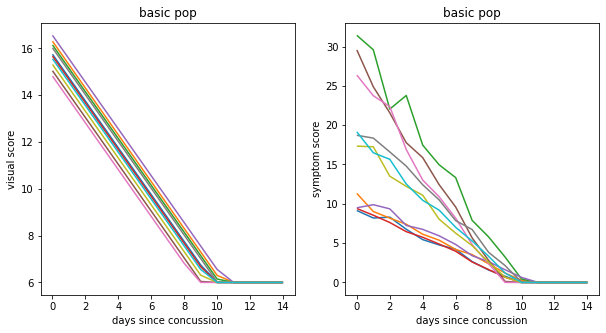

In [101]:
#test
def gen_f0(self, size):
    return random.normal(*uniform_to_normal((14, 18)), (size, 1))

def gen_a(self, size):
    return random.choice([1, 2, 3], (size, 1))

def gen_C_multiplicative(self, size, days):
    return random.normal(*uniform_to_normal((0.8, 1.2), pmsigma=3), (size, days))

popsize=10
basepop = Population(popsize, title='basic pop', gen_f0=gen_f0, gen_a=gen_a, gen_C=gen_C_multiplicative)
#linpop = Population(popsize, title='linear population with multiplicative error', symptomfunctiontype='linear', gen_C=gen_C_multiplicative)
#exppop = Population(popsize, title='exponential population with multiplicative error', symptomfunctiontype='exponential', gen_C=gen_C)

fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2.0)*1.25)
ndays = 15
basepop.plot(axes[0], ndays=ndays, score='visual')
basepop.plot(axes[1], ndays=ndays, score='symptom')
plt.show()

Intersting to note: the heterostatic error seems less pronounced for exponential symptoms.
This is likely due to its large slope early on, as an increase of the same amount which is about -1 days for the linear will seem like much less time difference for exponential. 
The opposite is true later on, when the exponential curve is slower than the linear one.

# Recreating the poster

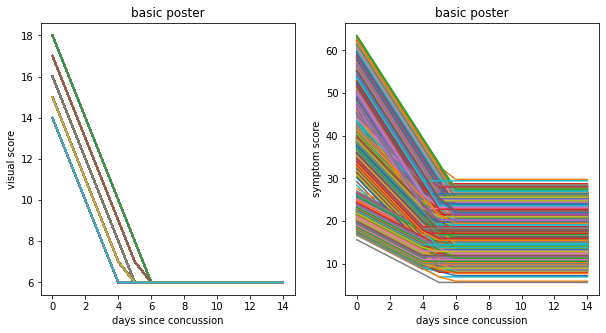

In [47]:
FMIN = 6 #minimum possible visual score
SMIN = float('-inf') #minimum possible symptom score
NDAYS = 160 #number of days in the study
def gen_f0(self):
    return random.randint(14,18+1)
def gen_r(self):
    return 2
def gen_a(self):
    return random.randint(1, 3+1)
def gen_s0(self):
    return random.normal(6, 2)
def gen_C(self):
    #return random.uniform(0.7, 1.3)
    return 1

popsize=1000
pop = Population(popsize, title='basic poster', symptomfunctiontype='linear with intercept', gen_f0=gen_f0, gen_r=gen_r, gen_a=gen_a, gen_s0=gen_s0, gen_C=gen_C)

fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2)*1.25)
ndays = 15
pop.plot(axes[0], ndays=ndays, score='visual')
pop.plot(axes[1], ndays=ndays, score='symptom')
plt.show()

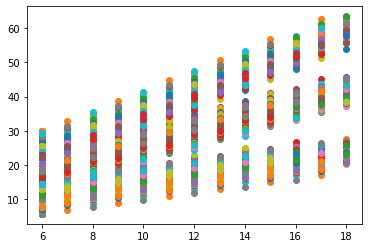

In [48]:
fig2, ax2 = plt.subplots()
for person in pop.persons:
    ax2.scatter(person.visualscores, person.symptomscores)
ax.set(xlabel='visual score', ylabel='symptom score')
plt.show()